In [2]:
import numpy as np
import matplotlib.pylab as plt
import numpy.random as rd

from sklearn.datasets import fetch_openml # MNIST data
from sklearn.model_selection import train_test_split

#os.environ["CUDA_VISIBLE_DEVICES"] = '0'
#sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

Using TensorFlow backend.


Exercise class:

### Convolutional neural networks
- Images are composed of high-dimensional data
- Invariance under small deformations (translation, rotations)
- Dense layers are bad!
- "Object recognition with gradient based learning", LeCun at al, around 1980

- Convolution: $f * g(t) = \int_{-\infty}^{\infty} f(t - \tau) g(\tau) d\tau$
- 1D -> 2D: move filter g over data f
- Use pooling (e.g. MaxPooling) for computational efficiency and translational invariance
- DO NOT FUCKING FORGET THE "Flatten()" COMMAND IF YOU FEED HIGH-DIMENSIONAL DATA INTO A DENSE LAYER!!!!!
- Then use categorical cross-entropy

Other layer types:
- Dropout: for each training sample -> ignore fraction (30%) of nodes, corresponds to regularization (network becomes not too specialized for recognizing certain samples), doubles time to convergence
- BatchNorm: apply normalization WITHIN the network (not only to input data, but also to intermediate stages); 
minimize weight shift due to statistics
- using BatchNorm -> have to use less Dropout

np.s_ is a slice object: standard python function slice(..)
-> useful for saving indizes of an object to a variable

## A1 - MNIST - Conv2D

### A1 - a - Place handwritten digits on canvas

In [3]:
# import MNIST data set
X_784, y_784 = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
# we place each 28x28 pixel MNIST image into a 50x50 pixel canvas
# to not encounter overlaps with the boundaries, the effective
# field for the upper left hand edge of the 28x28 image is limited 
# to (50-28) x (50-28)

def place_on_canvas(canvas_length, sample_number, imgarray_old, classarray_old, plot=False):
    
    image_length = int(np.sqrt(imgarray_old.shape[1]))
    edge_endpoint = canvas_length-image_length
    imgarray_new = []
    classarray_new = []
    
    # draw random image indices from old image array
    img_indices = rd.randint(0,imgarray_old.shape[0], size=sample_number) 
    
    # place images to according positions in an 1D 50x50=2500 array
    # at the position rdpos_y * canvas_length + rdpos_x
    for img_ind in img_indices:
        image_old = imgarray_old[img_ind]
        
        # draw random position of image edge on canvas
        canvas = np.zeros(canvas_length**2)
        rdpos = rd.randint(0,edge_endpoint, size=(1,2))[0]
        pos_old = 0 # running variable for 1D old array

        # fill 28x28 space on the canvas array with image entries
        for y_coord in range(rdpos[1], int(rdpos[1]+image_length) ):
            for x_coord in range(rdpos[0], int(rdpos[0]+image_length) ):
                   
                canvas[y_coord*canvas_length+x_coord] = image_old[pos_old]
                #print(y_coord, x_coord, pos_old)
                pos_old+=1
                
        # save new image and associated class
        imgarray_new.append(canvas)
        classarray_new.append(classarray_old[img_ind])
     
        if plot == True:
            plt.figure()
            plt.imshow(imgarray_old[img_ind].reshape(28, 28), interpolation='nearest',
                       cmap=plt.cm.YlGnBu)      
            plt.title("Old Image")
            plt.figure()
            plt.imshow(canvas.reshape(50, 50), interpolation='nearest',
                       cmap=plt.cm.YlGnBu)
            plt.title("New Image")
    
    return imgarray_new, classarray_new


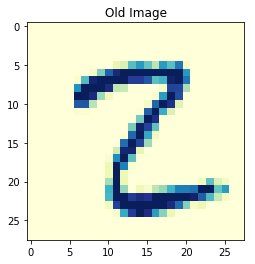

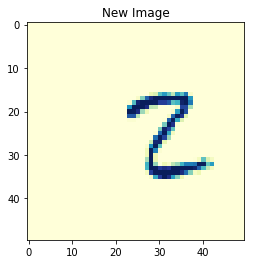

In [5]:
# parameters
canvas_length = 50
sample_number = 10000

# plot a sample
X_2500, y_2500 = place_on_canvas(canvas_length, 1, X_784, y_784, plot=True)

# obtain the images placed on a 50x50 canvas
X_2500, y_2500 = place_on_canvas(canvas_length, sample_number, X_784, y_784, plot=False)
X_2500 = np.asarray(X_2500)
y_2500 = np.asarray(y_2500)

### A1 - b - Single Dense Layer Model

In [13]:
# build model with one dense hidden layer
model = Sequential()
model.add(Flatten())
model.add(Dense(units=250, activation="relu", input_shape=(50,50,1) ))
model.add(Dense(units=10, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

epochs = 10
#model.fit(X_2500, y_2500, epochs=epochs, validation_split=0.33)

# split in train and test and format input tensor
X_2500_train, X_2500_test, y_2500_train, y_2500_test = train_test_split(X_2500, y_2500)
X_2500_train = np.array(X_2500_train.reshape(X_2500_train.shape[0], 50, 50,1))
X_2500_test = np.array(X_2500_test.reshape(X_2500_test.shape[0], 50, 50,1))


# format y vector into categorical vector
from keras.utils import to_categorical
y_2500_train = np.array(to_categorical(y_2500_train))
y_2500_test = np.array(to_categorical(y_2500_test))

print(X_2500_train.shape)
print(y_2500_train.shape)

# fit model
model.fit(X_2500_train, y_2500_train, epochs=epochs, validation_data=(X_2500_test, y_2500_test))
model.summary()

(7500, 50, 50, 1)
(7500, 10)
Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 4s 544us/step - loss: 14.4439 - acc: 0.1029 - val_loss: 14.4550 - val_acc: 0.1032
Epoch 2/10
7500/7500 [==============================] - 3s 438us/step - loss: 14.5464 - acc: 0.0975 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/10
7500/7500 [==============================] - 4s 507us/step - loss: 14.5471 - acc: 0.0975 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/10
7500/7500 [==============================] - 4s 470us/step - loss: 14.5471 - acc: 0.0975 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/10
7500/7500 [==============================] - 3s 462us/step - loss: 14.5471 - acc: 0.0975 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/10
7500/7500 [==============================] - 4s 534us/step - loss: 14.5471 - acc: 0.0975 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/10
7500/7500 [==============================] - 4s 483us/step - loss: 14.5471 - acc: 0.

In [7]:
#for i in range(10):
 #   sample = X_2500_test[i].reshape((50,50))
    #print(sample)
  #  plt.figure()
   # plt.title("Classified as: %s / Predicted: %s" % (y_2500_test[i], model.predict(X_2500_test)[0]  ))
    #plt.imshow(sample, cmap = "Greys", interpolation = "nearest")
   # print(X_2500_test)

### A1 - c - Convolutional Model

In [10]:
# prepare convolutional model
cmodel = Sequential()
cmodel.add(Dense(units=64, activation="relu"))
cmodel.add(Conv2D(filters = 64, input_shape=(50,50,1), kernel_size=3, padding="same", strides=(1,1)))
cmodel.add(MaxPooling2D(pool_size=(2,2)) )
cmodel.add(Conv2D(filters = 32, kernel_size=3, padding="same", strides=(1,1)))
cmodel.add(MaxPooling2D(pool_size=(2,2)) )
cmodel.add(Flatten())
cmodel.add(Dense(units=10, activation="softmax"))

cmodel.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
epochs = 10
cmodel.fit(X_2500_train, y_2500_train, epochs=epochs, validation_data=(X_2500_test, y_2500_test))

cmodel.summary()

Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 72s 10ms/step - loss: 3.9009 - acc: 0.2624 - val_loss: 2.1487 - val_acc: 0.3884
Epoch 2/10
7500/7500 [==============================] - 74s 10ms/step - loss: 1.5892 - acc: 0.5093 - val_loss: 1.8091 - val_acc: 0.4700
Epoch 3/10
7500/7500 [==============================] - 71s 9ms/step - loss: 1.1026 - acc: 0.6452 - val_loss: 1.7962 - val_acc: 0.5272
Epoch 4/10
7500/7500 [==============================] - 72s 10ms/step - loss: 0.9423 - acc: 0.6993 - val_loss: 1.3721 - val_acc: 0.6092
Epoch 5/10
7500/7500 [==============================] - 74s 10ms/step - loss: 0.7309 - acc: 0.7651 - val_loss: 1.4964 - val_acc: 0.5908
Epoch 6/10
7500/7500 [==============================] - 73s 10ms/step - loss: 0.5531 - acc: 0.8208 - val_loss: 1.4328 - val_acc: 0.6460
Epoch 7/10
7500/7500 [==============================] - 75s 10ms/step - loss: 0.4138 - acc: 0.8601 - val_loss: 1.6049 - val_acc: 0.6296
E

Input: 50 x 50 x 1

Output: N_channels = 16
Filter: 5 x 5
We have an output size of: 50 - (5-1) = 46 
-> 46 x 46 x 16

Then Pooling:
23 x 23 x 16

## A2 - Network Analysis

### A2 - a - Identify incorrectly classified samples

Exercise_class: 

- 1) Plot activations for each channel and each layer
- 2) plug in random images, pick a layer activation, do gradient descent on input pixels -> NN generates picture that fits layer, see Google DeepDream

In [149]:
# import CIFAR_10 data set
X, y = fetch_openml('CIFAR_10_small', version=1, return_X_y=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 64)        18496     
__________

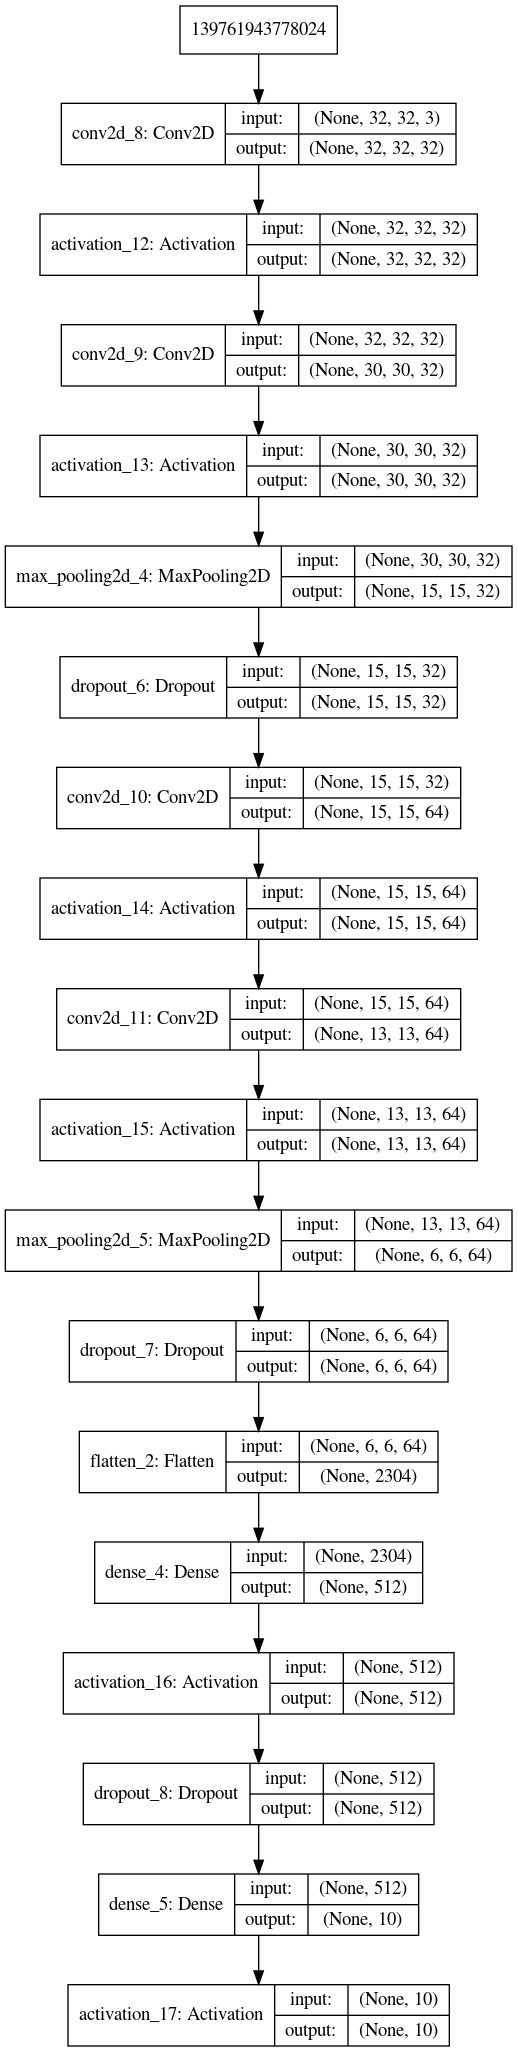

In [150]:
# load given model (adjust path if necessary)
import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

path = "/home/mario/LMUcloud/machinelearning/5/keras_cifar10_trained_model.h5"
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        model = load_model(path)

# visualize imported model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, "model.png", show_shapes=True, show_layer_names=True)
model.summary()
Image("model.png")

In [2]:
# labels to categorical
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Score trained model
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0], 32, 32,3)
X_test = X_test.reshape(X_test.shape[0], 32, 32,3)
scores = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# seek wrongly predicted samples
print("Wrongly predicted")
for i in range(20):
    if model.predict_classes([X_test[i]])[0] != y_test[i]:
        plt.figure()
        plt.title("Classified as: %s / Predicted: %s" % (y_test[i], model.predict([X_test[i]])[0] ))
        print(X_test[i][0][0])
        plt.imshow(X_test[i][0][0], interpolation = "nearest")

NameError: name 'keras' is not defined

### A2 - b - Visualise activation of hidden layers

In [1]:
# visualize the average activation of hidden layers
def visualize_layers(classifier):
    layer_names = []
    for layer in classifier.layers[:12]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    images_per_row = 16
    
    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
visualize_layers(model)

NameError: name 'model' is not defined

In [ ]:
# Extracts the outputs of the top 12 layers
#layer_outputs = [layer.output for layer in classifier.layers[:12]] 

# Creates a model that will return these outputs, given the model input
#activation_model = models.Model(inputs=classifier.input, outputs=layer_outputs) 

# Returns a list of five Numpy arrays: one array per layer activation
#activations = activation_model.predict(X_train[0]) 
#first_layer_activation = activations[0]
#print(first_layer_activation.shape)
#plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

#https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md